Epoch 10 | Train Loss: 0.3753 | Val Loss: 0.3644 | Val Acc: 0.835
Epoch 20 | Train Loss: 0.2749 | Val Loss: 0.2819 | Val Acc: 0.855
Epoch 30 | Train Loss: 0.2619 | Val Loss: 0.2741 | Val Acc: 0.865
Epoch 40 | Train Loss: 0.2598 | Val Loss: 0.2735 | Val Acc: 0.865
Epoch 50 | Train Loss: 0.2592 | Val Loss: 0.2732 | Val Acc: 0.865
Epoch 60 | Train Loss: 0.2586 | Val Loss: 0.2730 | Val Acc: 0.865
Epoch 70 | Train Loss: 0.2584 | Val Loss: 0.2722 | Val Acc: 0.860
Epoch 80 | Train Loss: 0.2581 | Val Loss: 0.2722 | Val Acc: 0.865
Epoch 90 | Train Loss: 0.2577 | Val Loss: 0.2713 | Val Acc: 0.860
Epoch 100 | Train Loss: 0.2576 | Val Loss: 0.2713 | Val Acc: 0.865
Test Accuracy: 0.870


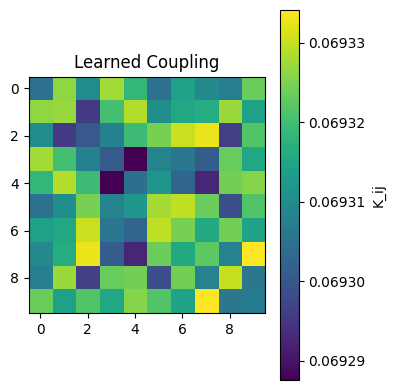

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn.functional import softplus

# 1) Data split as before
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32, device=device),
                         torch.tensor(y_train, dtype=torch.long,    device=device))
val_ds   = TensorDataset(torch.tensor(X_val,   dtype=torch.float32, device=device),
                         torch.tensor(y_val,   dtype=torch.long,    device=device))
test_ds  = TensorDataset(torch.tensor(X_test,  dtype=torch.float32, device=device),
                         torch.tensor(y_test,  dtype=torch.long,    device=device))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)
test_loader  = DataLoader(test_ds,  batch_size=64)

# 2) Define the shared‑frequency oscillator net
class SharedFreqOscillatorNet(nn.Module):
    def __init__(self, input_dim, num_osc, T=2.0, dt=0.1, freq_scale=1.0):
        super().__init__()
        self.N           = num_osc
        self.steps       = int(T / dt)
        self.dt          = dt
        self.freq_scale  = freq_scale
        
        # map input -> single scalar frequency
        self.fc_in = nn.Linear(input_dim, 1)
        
        # free A to build symmetric positive coupling
        self.A = nn.Parameter(torch.randn(self.N, self.N) * 0.1)
        
        # read‑out
        self.fc_out = nn.Linear(2*self.N, 2)

    def forward(self, x):
        batch = x.size(0)
        
        # 1) compute shared freq and broadcast
        raw_freq = self.fc_in(x)                     # (batch, 1)
        freq     = torch.tanh(raw_freq) * self.freq_scale  # (batch, 1)
        omega    = freq.repeat(1, self.N)            # (batch, N)
        
        # 2) build symmetric positive coupling matrix
        K = softplus(self.A + self.A.t()) / self.N   # (N, N)
        
        # 3) init phases at zero
        theta = torch.zeros(batch, self.N, device=x.device)
        
        # 4) integrate
        for _ in range(self.steps):
            th_i     = theta.unsqueeze(2)   # (batch, N, 1)
            th_j     = theta.unsqueeze(1)   # (batch, 1, N)
            sin_diff = torch.sin(th_j - th_i)    # (batch, N, N)
            coup     = torch.einsum('bij,ij->bi', sin_diff, K)  # (batch, N)
            theta    = theta + self.dt * (omega + coup)
        
        # 5) read‑out features
        feats = torch.cat([torch.cos(theta), torch.sin(theta)], dim=1)
        return self.fc_out(feats)

# 3) Instantiate, loss, optimizer (with L1 on A)
model = SharedFreqOscillatorNet(input_dim=2, num_osc=10, T=2.0, dt=0.05, freq_scale=1.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
l1_lambda = 1e-3   # strength of coupling regularization

# 4) Train with L1 on coupling A
epochs = 100
for epoch in range(1, epochs+1):
    # train phase
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        # add L1 penalty on A
        l1_reg = l1_lambda * torch.norm(model.A, p=1)
        (loss + l1_reg).backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    
    # val phase
    model.eval()
    total_val = 0.0
    correct   = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss   = criterion(logits, yb)
            total_val += loss.item() * xb.size(0)
            correct   += (logits.argmax(1)==yb).sum().item()
    val_loss = total_val / len(val_loader.dataset)
    val_acc  = correct / len(val_loader.dataset)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")

# 5) Final test accuracy
model.eval()
correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb).argmax(1)
        correct += (preds==yb).sum().item()
print(f"Test Accuracy: {correct/len(test_loader.dataset):.3f}")

# 6) Visualize coupling matrix
K_learned = softplus(model.A + model.A.t()).detach().cpu().numpy() / model.N
plt.figure(figsize=(4,4))
plt.imshow(K_learned, cmap='viridis', aspect='equal')
plt.title('Learned Coupling')
plt.colorbar(label='K_ij')
plt.tight_layout()
plt.show()


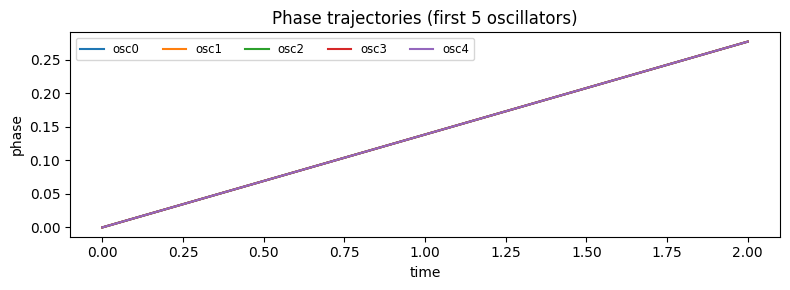

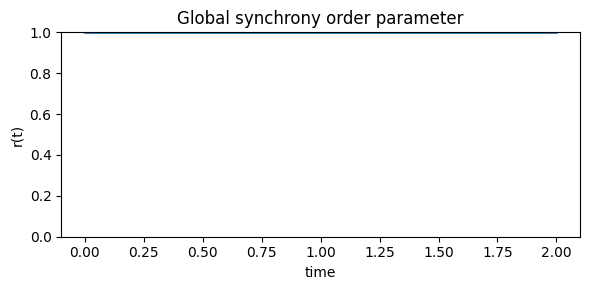

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import softplus

def record_phases_shared(net, x, total_time=2.0, dt=0.1):
    """
    Record phase trajectories for a single input x using SharedFreqOscillatorNet.

    Parameters
    ----------
    net : SharedFreqOscillatorNet
        Your trained model instance.
    x : torch.Tensor, shape (input_dim,)
        Single input example on the same device as net.
    total_time : float
        Total simulation time.
    dt : float
        Integration time step.

    Returns
    -------
    traj : np.ndarray, shape (steps, N)
        Phases of each of the N oscillators at each time step.
    """
    net.eval()
    with torch.no_grad():
        # 1) compute shared frequency and broadcast
        raw_freq = net.fc_in(x.unsqueeze(0))            # (1, 1)
        freq     = torch.tanh(raw_freq) * net.freq_scale  # (1, 1)
        omega    = freq.repeat(1, net.N)                # (1, N)

        # 2) build symmetric positive coupling matrix
        A = net.A                                        # (N, N)
        coupling_mat = softplus(A + A.t()) / net.N       # (N, N)

        # 3) initialize phases to zero
        phase = torch.zeros(1, net.N, device=x.device)   # (1, N)

        # 4) allocate trajectory array
        steps = int(total_time / dt)
        traj = np.zeros((steps, net.N))

        # 5) integrate with forward Euler
        for t in range(steps):
            traj[t] = phase.cpu().numpy()
            pi = phase.unsqueeze(2)        # (1, N, 1)
            pj = phase.unsqueeze(1)        # (1, 1, N)
            sin_diff = torch.sin(pj - pi)  # (1, N, N)
            coup     = torch.einsum('bij,ij->bi', sin_diff, coupling_mat)  # (1, N)
            phase    = phase + dt * (omega + coup)

    return traj

# ------------------------------
# Example usage:

# assume `model` is your trained SharedFreqOscillatorNet
# assume `test_ds` is your test dataset wrapped in a TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# pick the first test example
X_test_np, y_test_np = test_ds.tensors[0].cpu().numpy(), test_ds.tensors[1].cpu().numpy()
x0 = torch.tensor(X_test_np[0], dtype=torch.float32, device=device)

# record the phases
T, dt = 2.0, 0.05
traj = record_phases_shared(model, x0, total_time=T, dt=dt)  # shape (steps, N)
times = np.linspace(0, T, traj.shape[0])

# plot first 5 oscillator phases
plt.figure(figsize=(8, 3))
for i in range(min(5, traj.shape[1])):
    plt.plot(times, traj[:, i], label=f'osc{i}')
plt.xlabel('time')
plt.ylabel('phase')
plt.title('Phase trajectories (first 5 oscillators)')
plt.legend(ncol=5, fontsize='small')
plt.tight_layout()
plt.show()

# compute and plot global order parameter r(t)
r = np.abs(np.exp(1j * traj).mean(axis=1))
plt.figure(figsize=(6, 3))
plt.plot(times, r, lw=2)
plt.ylim(0, 1)
plt.xlabel('time')
plt.ylabel('r(t)')
plt.title('Global synchrony order parameter')
plt.tight_layout()
plt.show()
